In [ ]:
import sys
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt


ROOT = Path.cwd().resolve()
if (ROOT / 'src').exists():
    sys.path.insert(0, str(ROOT))
elif (ROOT.parent / 'src').exists():
    sys.path.insert(0, str(ROOT.parent))


In [2]:
import numpy as np
import pandas as pd

from src.data.loading import build_ratings_matrix, build_user_folds
from src.eval.metrics import evaluate_all_metrics
from src.models.baselines import (
    global_mean,
    user_mean,
    item_mean,
    random_baseline,
    popularity_baseline,
)
from src.models.cf import evaluate_user_based_cf, evaluate_item_based_cf
from src.models.mf import evaluate_mf_with_metrics_on_folds
from src.models.svdpp import evaluate_svdpp_with_metrics_on_folds

from cluster_simulation import generate_mask_zipf_global, fill_ratings_clusters


In [3]:
U, I = 1000, 2000
pairs, uc, ic, A = generate_mask_zipf_global(
    U,
    I,
    density=0.063,
    alpha_user=0.9,
    alpha_item=0.9,
    seed=42,
    min_user_ratings=20,
    min_item_ratings=5,
    n_user_clusters=12,
    n_item_clusters=18,
    beta=1,
    return_clusters=True,
)

R_syn = fill_ratings_clusters(
    U=U,
    I=I,
    pairs=pairs,
    user_cluster=uc,
    item_cluster=ic,
    tau=np.array([-1.2, -0.4, 0.4, 1.2]),
    seed=42,
    mu=0,
    sigma_bu=0.5,
    sigma_bi=0.5,
    sigma_eps=0.4,
    gamma=0.4,
    A=A,
)

ratings_long = pd.DataFrame(R_syn).stack().reset_index()
ratings_long.columns = ['UserID', 'MovieID', 'Rating']
ratings_long.head()


,UserID,MovieID,Rating
0,0,0,3.0
1,0,40,2.0
2,0,65,3.0
3,0,92,5.0
4,0,94,3.0


In [4]:
ratings_matrix = build_ratings_matrix(ratings_long)
folds = build_user_folds(ratings_matrix, n_splits=5, test_ratings_per_user=5, random_state=42)
train_df, test_df = folds[0]
train_df.head()


MovieID,0,1,2,3,4,5,6,7,8,9,...,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999
UserID,,,,,,,,,,,,,,,,,,,,,
0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2.0,2.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
R_train, R_test = train_df.values, test_df.values
baselines = [
    ('Global Mean', global_mean(train_df).values),
    ('User Mean', user_mean(train_df).values),
    ('Item Mean', item_mean(train_df).values),
    ('Random [min,max]', random_baseline(train_df).values),
    ('Popularity', popularity_baseline(train_df).values),
]
metrics = []
for name, R_pred in baselines:
    metrics.append({**evaluate_all_metrics(R_train, R_test, R_pred, train_df), 'Model': name})
pd.DataFrame(metrics)


,RMSE,MAE,Novelty,Relevance,Serendipity,Diversity,nDCG@20,Model
0,1.077657,0.909720,4.792727,3.600000,0.544577,0.850185,0.007880,Global Mean
1,0.893790,0.734598,4.792727,3.600000,0.544577,0.850185,0.007880,User Mean
2,0.903842,0.741694,4.589175,4.750000,0.900217,0.822179,0.003501,Item Mean
3,1.619682,1.323022,4.556382,3.272727,0.272924,0.837466,0.006685,"Random [min,max]"
4,2.052817,1.757462,1.277035,3.163420,0.165218,0.376696,0.194641,Popularity


In [10]:
metrics_df = pd.DataFrame(metrics)
ref_rmse = metrics_df.loc[metrics_df['Model'] == 'Global Mean', 'RMSE'].iloc[0]
metrics_df['Relative RMSE'] = metrics_df['RMSE'] / ref_rmse
metrics_df


,RMSE,MAE,Novelty,Relevance,Serendipity,Diversity,nDCG@20,Model,Relative RMSE
0,1.077657,0.909720,4.792727,3.600000,0.544577,0.850185,0.007880,Global Mean,1.000000
1,0.893790,0.734598,4.792727,3.600000,0.544577,0.850185,0.007880,User Mean,0.829382
2,0.903842,0.741694,4.589175,4.750000,0.900217,0.822179,0.003501,Item Mean,0.838710
3,1.619682,1.323022,4.556382,3.272727,0.272924,0.837466,0.006685,"Random [min,max]",1.502966
4,2.052817,1.757462,1.277035,3.163420,0.165218,0.376696,0.194641,Popularity,1.904889


In [ ]:
mu_values = [-0.8, -0.4, 0.0, 0.4, 0.8]
rows = []

for mu in mu_values:
    R_syn = fill_ratings_clusters(
        U=U,
        I=I,
        pairs=pairs,
        user_cluster=uc,
        item_cluster=ic,
        tau=np.array([-1.2, -0.4, 0.4, 1.2]),
        seed=42,
        mu=mu,
        sigma_bu=0.5,
        sigma_bi=0.5,
        sigma_eps=0.4,
        gamma=0.4,
        A=A,
    )

    ratings_long = pd.DataFrame(R_syn).stack().reset_index()
    ratings_long.columns = ['UserID', 'MovieID', 'Rating']
    ratings_matrix = build_ratings_matrix(ratings_long)
    folds = build_user_folds(ratings_matrix, n_splits=5, test_ratings_per_user=5, random_state=42)
    train_df, test_df = folds[0]

    R_train, R_test = train_df.values, test_df.values
    baselines = [
        ('Global Mean', global_mean(train_df).values),
        ('User Mean', user_mean(train_df).values),
        ('Item Mean', item_mean(train_df).values),
        ('Random [min,max]', random_baseline(train_df).values),
        ('Popularity', popularity_baseline(train_df).values),
    ]

    metrics = []
    for name, R_pred in baselines:
        metrics.append({**evaluate_all_metrics(R_train, R_test, R_pred, train_df), 'Model': name})

    metrics_df = pd.DataFrame(metrics)
    ref_rmse = metrics_df.loc[metrics_df['Model'] == 'Global Mean', 'RMSE'].iloc[0]
    metrics_df['Relative RMSE'] = metrics_df['RMSE'] / ref_rmse
    metrics_df['mu'] = mu
    rows.append(metrics_df[['mu', 'Model', 'RMSE', 'Relative RMSE']])

mu_sweep_df = pd.concat(rows, ignore_index=True)


,mu,Model,RMSE,Relative RMSE
0,-0.8,Global Mean,1.056062,1.000000
1,-0.8,User Mean,0.882244,0.835409
2,-0.8,Item Mean,0.885990,0.838956
3,-0.8,"Random [min,max]",1.709820,1.619052
4,-0.8,Popularity,1.590537,1.506101
5,-0.4,Global Mean,1.089255,1.000000
6,-0.4,User Mean,0.906152,0.831901
7,-0.4,Item Mean,0.910277,0.835688
8,-0.4,"Random [min,max]",1.628452,1.495014
9,-0.4,Popularity,1.791992,1.645155


In [15]:
alpha_values = [0.2, 0.9, 1.5]
rows = []

for alpha_user in alpha_values:
    for alpha_item in alpha_values:
        pairs, uc, ic, A = generate_mask_zipf_global(
            U,
            I,
            density=0.063,
            alpha_user=alpha_user,
            alpha_item=alpha_item,
            seed=42,
            min_user_ratings=20,
            min_item_ratings=5,
            n_user_clusters=12,
            n_item_clusters=18,
            beta=1,
            return_clusters=True,
        )

        R_syn = fill_ratings_clusters(
            U=U,
            I=I,
            pairs=pairs,
            user_cluster=uc,
            item_cluster=ic,
            tau=np.array([-1.2, -0.4, 0.4, 1.2]),
            seed=42,
            mu=0,
            sigma_bu=0.5,
            sigma_bi=0.5,
            sigma_eps=0.4,
            gamma=0.4,
            A=A,
        )

        ratings_long = pd.DataFrame(R_syn).stack().reset_index()
        ratings_long.columns = ['UserID', 'MovieID', 'Rating']
        ratings_matrix = build_ratings_matrix(ratings_long)
        folds = build_user_folds(ratings_matrix, n_splits=5, test_ratings_per_user=5, random_state=42)
        train_df, test_df = folds[0]

        R_train, R_test = train_df.values, test_df.values
        baselines = [
            ('Global Mean', global_mean(train_df).values),
            ('User Mean', user_mean(train_df).values),
            ('Item Mean', item_mean(train_df).values),
            ('Random [min,max]', random_baseline(train_df).values),
            ('Popularity', popularity_baseline(train_df).values),
        ]

        metrics = []
        for name, R_pred in baselines:
            metrics.append({**evaluate_all_metrics(R_train, R_test, R_pred, train_df), 'Model': name})

        metrics_df = pd.DataFrame(metrics)
        ref_rmse = metrics_df.loc[metrics_df['Model'] == 'Global Mean', 'RMSE'].iloc[0]
        metrics_df['Relative RMSE'] = metrics_df['RMSE'] / ref_rmse
        metrics_df['alpha_user'] = alpha_user
        metrics_df['alpha_item'] = alpha_item
        rows.append(metrics_df[['alpha_user', 'alpha_item', 'Model', 'RMSE', 'Relative RMSE']])

alpha_sweep_df = pd.concat(rows, ignore_index=True)


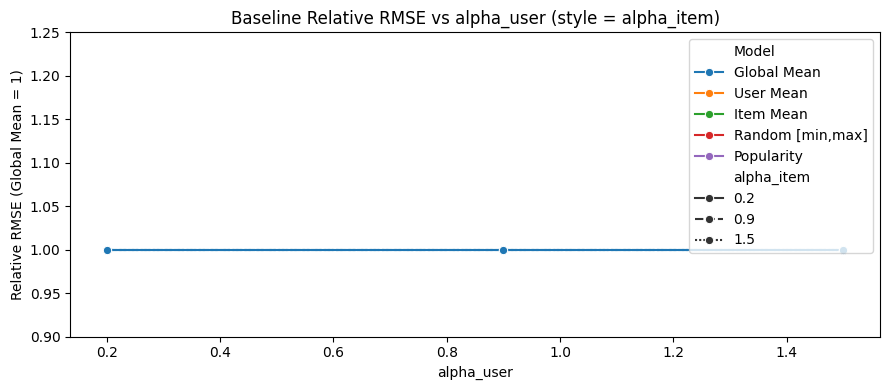

In [17]:

plt.figure(figsize=(9, 4))
sns.lineplot(
    data=alpha_sweep_df,
    x='alpha_user',
    y='Relative RMSE',
    hue='Model',
    style='alpha_item',
    marker='o',
)
plt.title('Baseline Relative RMSE vs alpha_user (style = alpha_item)')
plt.xlabel('alpha_user')
plt.ylabel('Relative RMSE (Global Mean = 1)')
plt.tight_layout()
plt.show()


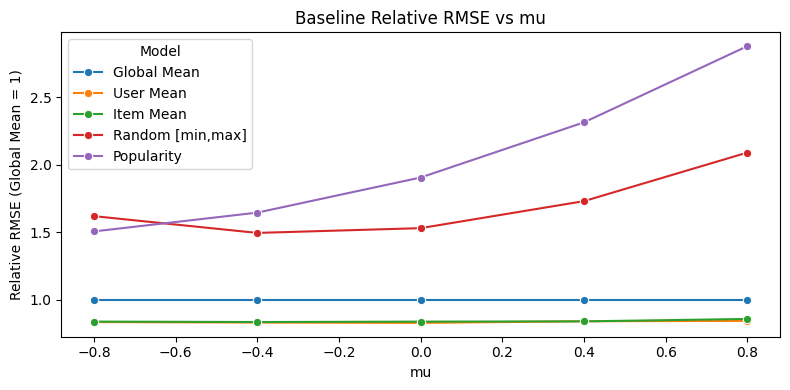

In [18]:

plt.figure(figsize=(8, 4))
sns.lineplot(data=mu_sweep_df, x='mu', y='Relative RMSE', hue='Model', marker='o')
plt.title('Baseline Relative RMSE vs mu')
plt.xlabel('mu')
plt.ylabel('Relative RMSE (Global Mean = 1)')
plt.tight_layout()
plt.show()


In [6]:
# User-based CF (Pearson):
# cf_user_metrics = evaluate_user_based_cf(folds)
# Item-based CF (cosine):
# cf_item_metrics = evaluate_item_based_cf(folds)
# Matrix factorization:
# mf_metrics_df, mf_avg_metrics = evaluate_mf_with_metrics_on_folds(folds)
# SVD++:
# svdpp_metrics_df, svdpp_avg_metrics = evaluate_svdpp_with_metrics_on_folds(folds, n_epochs=5)
